In [9]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
import os

# Use raw string to avoid backslash issues
input_path = r"D:\codes\Flood-Detection-Using-Deep-Learning-Model-From-Satellite-Images-\FloodDataset"

def print_file_sizes(input_path, subset):
	path = os.path.join(input_path, subset)
	print(f"\nSubset: {subset}")
	print("-" * 50)

	if not os.path.exists(path):
		print("❌ Path does not exist:", path)
		return

	total_files = 0
	total_size = 0.0

	for subfolder in os.listdir(path):
		subpath = os.path.join(path, subfolder)
		if not os.path.isdir(subpath):
			continue

		files = [
			os.path.join(subpath, f)
			for f in os.listdir(subpath)
			if os.path.isfile(os.path.join(subpath, f))
		]
		size_mb = round(sum(os.path.getsize(f) for f in files) / 1e6, 2)
		count = len(files)
		total_files += count
		total_size += size_mb

		print(f"{subfolder:<20} {count:>5} files | {size_mb:>8} MB")

	print("-" * 50)
	print(f"Total: {total_files} files | {round(total_size, 2)} MB\n")

print_file_sizes(input_path, 'test')
print_file_sizes(input_path, 'test_another')
print_file_sizes(input_path, 'validation_another')



Subset: test
--------------------------------------------------
damage                  78 files |      1.2 MB
notdamage              139 files |     2.37 MB
--------------------------------------------------
Total: 217 files | 3.57 MB


Subset: test_another
--------------------------------------------------
damage                  44 files |     0.72 MB
no_damage               44 files |     0.72 MB
--------------------------------------------------
Total: 88 files | 1.44 MB


Subset: validation_another
--------------------------------------------------
damage                  78 files |      1.2 MB
notdamage              139 files |     2.37 MB
--------------------------------------------------
Total: 217 files | 3.57 MB



In [49]:
from pathlib import Path
import pandas as pd
import random
import os

# Root dataset path
input_path = Path(r"D:\codes\Flood-Detection-Using-Deep-Learning-Model-From-Satellite-Images-\FloodDataset")

# Function to generate random coordinates
def random_coords():
    lon = round(random.uniform(68.0, 97.0), 4)   # India longitude approx range
    lat = round(random.uniform(8.0, 37.0), 4)    # India latitude approx range
    return f"{lon}_{lat}"

# Find all JPG files
image_paths = list(input_path.rglob("*.jpg"))

renamed_files = []
for p in image_paths:
    new_name = random_coords() + ".jpg"
    new_path = p.parent / new_name

    # Avoid overwriting files by regenerating if name already exists
    while new_path.exists():
        new_name = random_coords() + ".jpg"
        new_path = p.parent / new_name

    os.rename(p, new_path)
    renamed_files.append(new_path)

# Build dataframe
image_df = pd.DataFrame({
    'path': [str(p) for p in renamed_files],
    'subset': [p.parent.parent.stem for p in renamed_files],
    'damage_type': [p.parent.stem for p in renamed_files],
    'location': [p.stem for p in renamed_files],
})

# Extract lon/lat from filename
image_df['lon'] = image_df['location'].map(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[1]))

print("✅ Renaming complete.")
print("Total images renamed:", len(image_df))
print(image_df.head())

# Optionally save to CSV for reference
image_df.to_csv("renamed_image_data.csv", index=False)


✅ Renaming complete.
Total images renamed: 743
                                                path subset damage_type  \
0  D:\codes\Flood-Detection-Using-Deep-Learning-M...   test      damage   
1  D:\codes\Flood-Detection-Using-Deep-Learning-M...   test      damage   
2  D:\codes\Flood-Detection-Using-Deep-Learning-M...   test      damage   
3  D:\codes\Flood-Detection-Using-Deep-Learning-M...   test      damage   
4  D:\codes\Flood-Detection-Using-Deep-Learning-M...   test      damage   

          location      lon      lat  
0  73.4847_10.8241  73.4847  10.8241  
1   72.826_31.1869  72.8260  31.1869  
2  75.1011_21.8124  75.1011  21.8124  
3  70.0395_27.5188  70.0395  27.5188  
4  72.8718_30.8696  72.8718  30.8696  


Traning Labels


In [50]:
# find all .jpg files under the dataset root (recursively)
image_paths = list(Path(input_path).rglob('*.jpg'))
image_df = pd.DataFrame({'path': image_paths})

image_df['damage' ] = image_df['path'].map(lambda x: x.parent.stem)
image_df['date_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['location' ] = image_df['path'].map(lambda x: x.stem)
image_df['lon'] = image_df['location' ].map(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[-1]))
image_df['path'] = image_df['path'].map(lambda x: str(x)) # convert the path back to a string

image_df.head()

,path,damage,date_split,location,lon,lat
0,D:\codes\Flood-Detection-Using-Deep-Learning-M...,damage,test,68.2594_28.4081,68.2594,28.4081
1,D:\codes\Flood-Detection-Using-Deep-Learning-M...,damage,test,69.0005_26.2545,69.0005,26.2545
2,D:\codes\Flood-Detection-Using-Deep-Learning-M...,damage,test,69.6292_14.6657,69.6292,14.6657
3,D:\codes\Flood-Detection-Using-Deep-Learning-M...,damage,test,69.7496_18.3171,69.7496,18.3171
4,D:\codes\Flood-Detection-Using-Deep-Learning-M...,damage,test,69.7503_35.2211,69.7503,35.2211


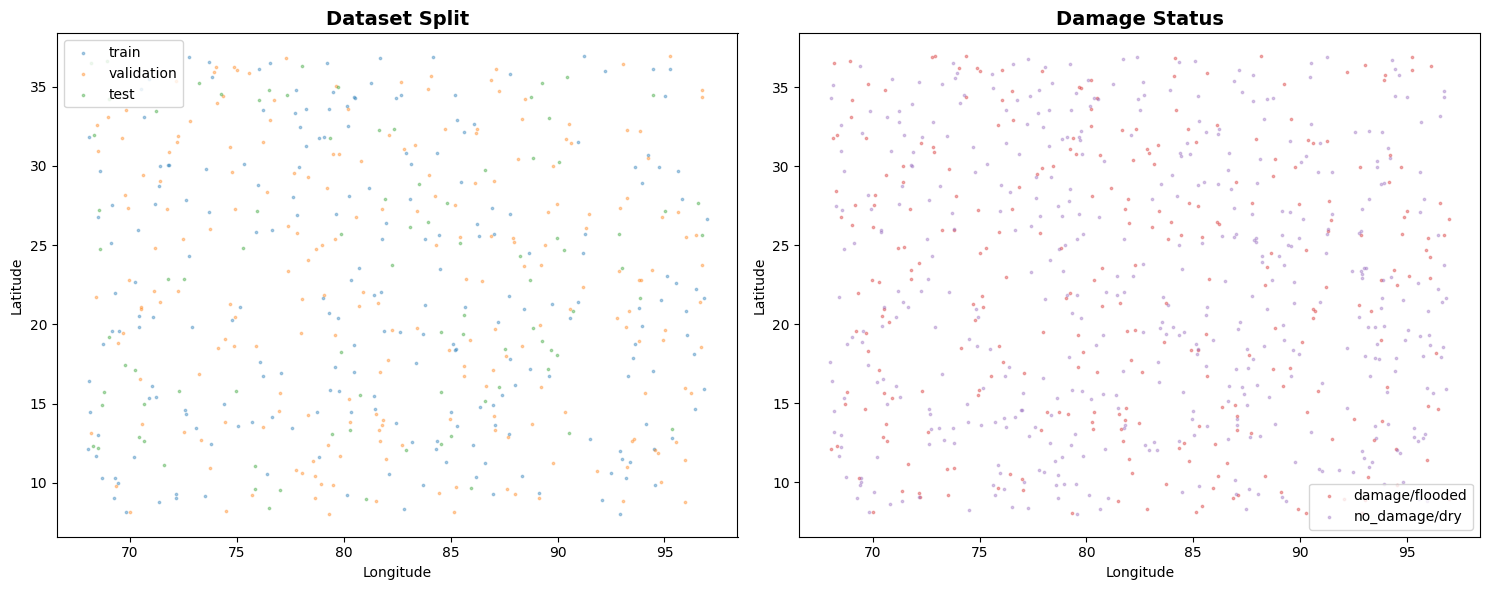

In [51]:
import matplotlib.pyplot as plt

# Create two subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

s = 3          # dot size
alpha = 0.35   # transparency

# ------------------ Data Splits ------------------
# Make sure the column name matches your DataFrame (you used 'date_split' earlier)
image_df_train = image_df[image_df['date_split'] == 'train_another'].copy()
image_df_val = image_df[image_df['date_split'] == 'validation_another'].copy()
image_df_test = image_df[image_df['date_split'] == 'test_another'].copy()

# Sort to ensure reproducibility
for df in [image_df_train, image_df_val, image_df_test]:
    df.sort_values('lat', inplace=True)
    df.reset_index(drop=True, inplace=True)

# Scatter plot for dataset splits
ax[0].scatter(image_df_train['lon'], image_df_train['lat'], color='C0', s=s, alpha=alpha, label='train')
ax[0].scatter(image_df_val['lon'], image_df_val['lat'], color='C1', s=s, alpha=alpha, label='validation')
ax[0].scatter(image_df_test['lon'], image_df_test['lat'], color='C2', s=s, alpha=alpha, label='test')

ax[0].set_title('Dataset Split', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# ------------------ Damage Status ------------------
# Make sure 'damage' column exists and contains correct values
image_df_dmg = image_df[image_df['damage'].str.lower().isin(['damage', 'flooded'])].copy()
image_df_nodmg = image_df[~image_df['damage'].str.lower().isin(['damage', 'flooded'])].copy()

for df in [image_df_dmg, image_df_nodmg]:
    df.reset_index(drop=True, inplace=True)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C3', s=s, alpha=alpha, label='damage/flooded')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C4', s=s, alpha=alpha, label='no_damage/dry')

ax[1].set_title('Damage Status', fontsize=14, fontweight='bold')
ax[1].legend()
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()


Training ima